## UCLA Results Validation Evaluation

In [13]:
from lib import analysis_utils as au
from keras import models as Kmodels
from keras import models as Kmodels
from keras import backend as Kbackend
from keras import applications as Kapplications
from keras import layers as Klayers
from keras import callbacks as Kcallbacks
from keras import optimizers as Koptimizers
from keras import losses as Klosses
from protestDB import cursor
import numpy as np
import scipy
from matplotlib import pyplot as plt
import time
from lib import transforms

### Load the data

In [2]:
pc = cursor.ProtestCursor()
imgs = pc.getLabelledImages(source="UCLA")
len(imgs)


40720

In [3]:
cols = ["name", "label", "protest"]
tag_cols = ["sign", "photo", "fire", "police", "children", "group_20", "group_100", "flag", "night", "shouting"]
split_tags = ['ucla-test', 'ucla-train']
imgs = imgs[cols + tag_cols + split_tags]
indx_non_violence = imgs['label'].isnull()

imgs.loc[:,tag_cols] = imgs.loc[:,tag_cols].astype(int)
imgs = imgs.rename(columns={"label": "violence"})
imgs

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.209786,True,1,0,0,0,0,1,1,0,1,0,True,False
c7c6cecccc6ae6a4,test-00001.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
94c4c6443cbc9c14,test-00002.jpg,0.122890,True,1,0,0,0,0,0,0,0,0,0,True,False
f2f068703a38e869,test-00003.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
83a2860706c6e5e4,test-00004.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
1890151c5859c8f8,test-00005.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
7f5b59cbdc543c2c,test-00006.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
6264e0c0a0c0a0d0,test-00007.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False
eee6e6e6c68f95b5,test-00008.jpg,NaN,False,0,0,0,0,0,0,0,0,0,0,True,False


### Pre processing

In [4]:
# Apply a cut point and normalize violence scores
cutpoint = 0.43

#clips
imgs = au.clipDFColumn(imgs, 'violence', cutpoint)

# normalize
imgs = au.minMax(imgs, 'violence')

# mask values that did not had violence labels
imgs.loc[indx_non_violence, "violence"] = -1
# df.loc[indx_non_violence, 'violence'] = -1

# masks the visual attributes that where image is not a protest
# for column, value in df.iloc[:,3:].iteritems(): # fill visual attributes with masking
#     df.loc[pd.isnull(df['protest']), column] = -1
imgs.loc[indx_non_violence, tag_cols] = -1
    
# fill nas
# df.fillna(0, inplace = True)

# df = imgs.rename(columns={"label": "violence"})
df = imgs
df

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting,ucla-test,ucla-train
imageHASH,,,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.487873,True,1,0,0,0,0,1,1,0,1,0,True,False
c7c6cecccc6ae6a4,test-00001.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
94c4c6443cbc9c14,test-00002.jpg,0.285790,True,1,0,0,0,0,0,0,0,0,0,True,False
f2f068703a38e869,test-00003.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
83a2860706c6e5e4,test-00004.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
1890151c5859c8f8,test-00005.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
7f5b59cbdc543c2c,test-00006.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
6264e0c0a0c0a0d0,test-00007.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False
eee6e6e6c68f95b5,test-00008.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,True,False


In [5]:
test_idx = df['ucla-test']
test = df.loc[test_idx, ["name", "violence", "protest"] + tag_cols]
test

,name,violence,protest,sign,photo,fire,police,children,group_20,group_100,flag,night,shouting
imageHASH,,,,,,,,,,,,,
030d92ca8d1f4b6b,test-00000.jpg,0.487873,True,1,0,0,0,0,1,1,0,1,0
c7c6cecccc6ae6a4,test-00001.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
94c4c6443cbc9c14,test-00002.jpg,0.285790,True,1,0,0,0,0,0,0,0,0,0
f2f068703a38e869,test-00003.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
83a2860706c6e5e4,test-00004.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1890151c5859c8f8,test-00005.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
7f5b59cbdc543c2c,test-00006.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
6264e0c0a0c0a0d0,test-00007.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
eee6e6e6c68f95b5,test-00008.jpg,-1.000000,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


### Load model

In [8]:
model_path = "models/UCLA_results_validation_datalen-40720_epochs-1000_init_lr-0.01_test.hdf5"; 

In [9]:
mask_value = -1
Kbackend.clear_session()

In [10]:
img_input = Klayers.Input(shape=(224,224,3), name='img_input')

resnet_model = Kapplications.ResNet50(include_top=False, weights = 'imagenet') (img_input)

flatten = Klayers.Flatten()(resnet_model)

protest_out = Klayers.Dense(1, activation='sigmoid', name='protest_out')(flatten)
violence_out = Klayers.Dense(1, activation='sigmoid', name='violence_out')(flatten)
visual_out = Klayers.Dense(10, activation='sigmoid', name='visual_out')(flatten)

model = Kmodels.Model(inputs= img_input, outputs=[protest_out, violence_out, visual_out])




In [11]:
lr = 0.01; momentum = 0.9; epochs = 1000; patience = 15
optimizer = Koptimizers.SGD(lr=lr, momentum=momentum, nesterov=False)
model.compile(optimizer=optimizer,
              loss={'protest_out': Klosses.binary_crossentropy,
                    'visual_out': au.buildMaskedLoss(Klosses.binary_crossentropy, mask_value), 
                    'violence_out': au.buildMaskedLoss(Klosses.mean_squared_error, mask_value)},
              loss_weights={'protest_out': 1., 
                            'visual_out': 5, 
                            'violence_out': 10 })
model.load_weights(model_path)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                multiple             23587712    img_input[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2048)         0           resnet50[1][0]                   
__________________________________________________________________________________________________
protest_out (Dense)             (None, 1)            2049        flatten_1[0][0]                  
__________________________________________________________________________________________________
violence_o

### Generator

In [15]:
dummy_test_generator = au.ResizeSequence(
    df[np.random.randint(100):np.random.randint(100, 200)],
    32, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ] 
)

test_generator = au.ResizeSequence(
    test,
    200, 
    targets = ['protest', 'violence', tag_cols],
    transforms = [
        transforms.resize,
        transforms.centerCrop,
        transforms.normalizeMinMax,
        transforms.normalizeStandardScore
    ]
)

test_visual = test[tag_cols]
test_violence = test['violence'] 
test_protest = test['protest']

protest has shape (32,)  violence has shape (32,)  visual has shape (32, 10)


/home/lucas/Documents/ITU/Thesis_2018/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


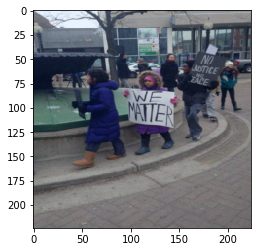

In [20]:
# test generator
first = dummy_test_generator.__getitem__(0)
image = first[0][0]
protest = first[1][0]
violence = first[1][1]
visual = first[1][2]
img = scipy.misc.toimage(image)
plt.imshow(img)

print("protest has shape", protest.shape, " violence has shape", violence.shape, " visual has shape", visual.shape)

### Predictions

In [ ]:
preds = model.predict_generator(test_generator, verbose = 1)
preds_protest = preds[0]
preds_violence = preds[1]
preds_visual = preds[2]
print("protest shape is ", preds_protest.shape, " violence shape is ", preds_violence.shape, "visual shape is ", preds_visual.shape)

In [14]:
preds_protest = preds[0][:len(test)] 
preds_violence = preds[1][:len(test)]
preds_visual = preds[2][:len(test)]
print("protest shape is ", preds_protest.shape, " violence shape is ", preds_violence.shape, "visual shape is ", preds_visual.shape)

protest shape is  (8152, 1)  violence shape is  (8152, 1) visual shape is  (8152, 10)


### Protest

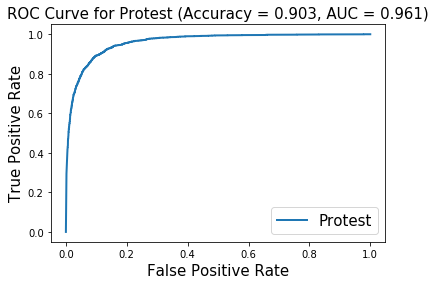

In [15]:
au.plotROC("protest", test_protest, preds_protest)

### Visual

sign


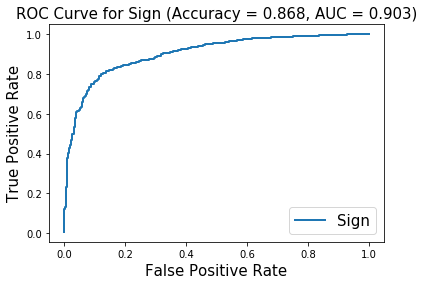

photo


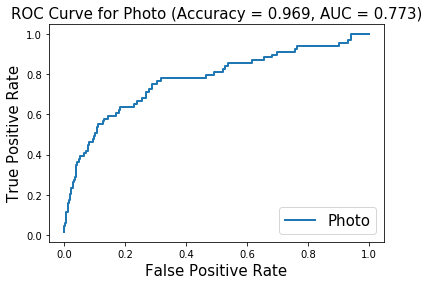

fire


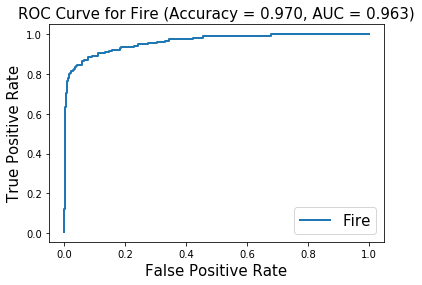

police


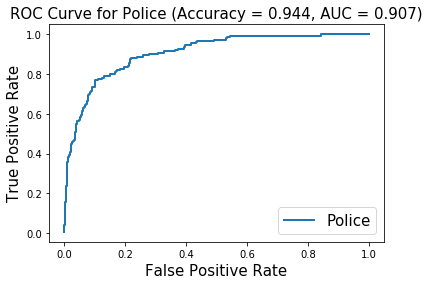

children


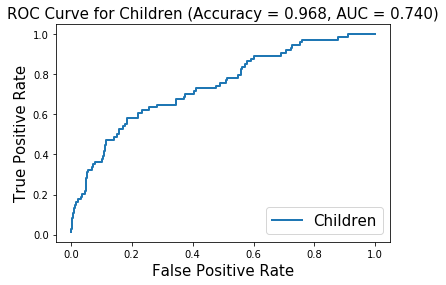

group_20


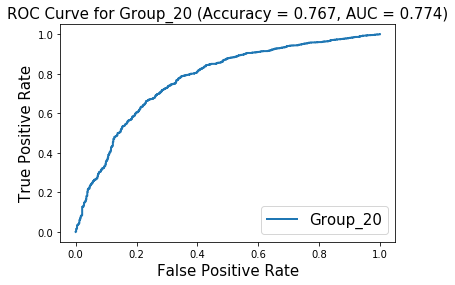

group_100


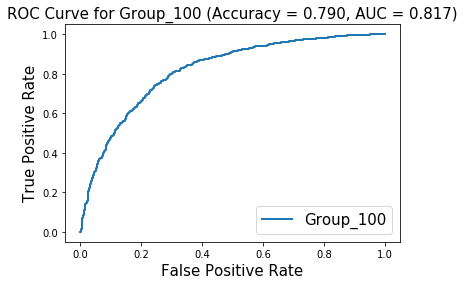

flag


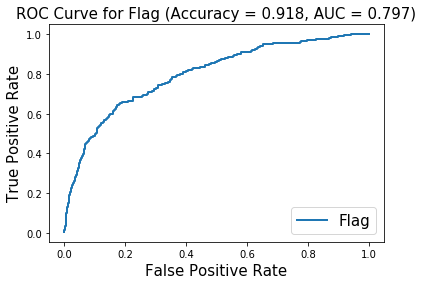

night


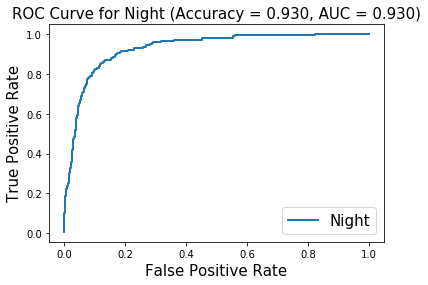

shouting


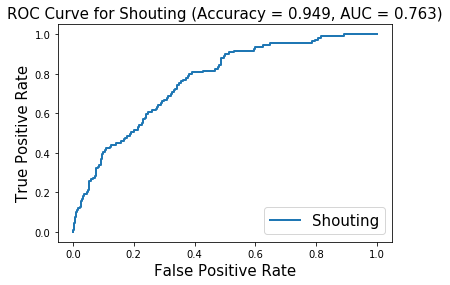

In [16]:
for i in range(preds_visual.shape[1]):
    pred = preds_visual[:,i]
    target = test_visual.iloc[:,i]
    
    # remove masked values from test set
    target_non_masked = target[target!= -1]
    pred_non_masked = pred[target!= -1]
    
    attr_indx = 3 + i # the visual attributes start from the 4th pos
    attr = df.columns[attr_indx]
    print(attr)
    try:
        au.plotROC(attr, target_non_masked, pred_non_masked)
    except Exception as e:
        print(e)

### Violence

In [17]:
# remove masked values from test set
non_masked_violence_true = test_violence[test_violence!= -1].tolist()
non_masked_violence_preds = preds_violence[test_violence!= -1].flatten().tolist()

Text(0.5,1,'Scatter Plot for violence (Correlation = 0.865, R_squared = 0.748 )')

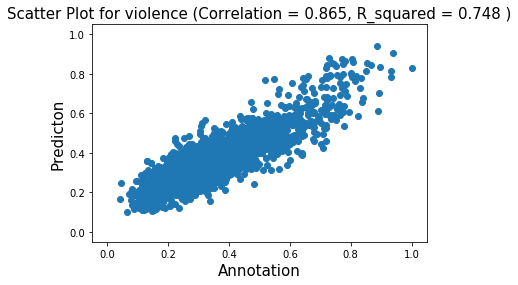

In [18]:
fig, ax = plt.subplots()
plt.scatter(non_masked_violence_true, non_masked_violence_preds, label = "violence")
plt.xlim([-.05,1.05])
plt.ylim([-.05,1.05])
plt.xlabel('Annotation', fontsize = 15)
plt.ylabel('Predicton', fontsize = 15)
corr, pval = scipy.stats.pearsonr(non_masked_violence_true, non_masked_violence_preds)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(non_masked_violence_true,non_masked_violence_preds)
r_squared = r_value ** 2
plt.title(('Scatter Plot for {attr} (Correlation = {corr:.3f}, R_squared = {r_2:.3f} )'
            .format(attr = "violence", corr= corr, r_2 = r_squared  )), fontsize = 15)